In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import rand_score, adjusted_rand_score
import networkx as nx
import torch
import torch.nn as nn


from libraries.preprocess import load_ts_dataset, distance_matrix, epsilon_graph_hard, epsilon_graph_mean
from libraries.nmf import nmf, nmf_sklearn, semi_nmf, sym_nmf, rgnmf_multi, kernel_nmf, sparse_nmf
from libraries.clustering_algos import kmeans, gaussian_mixture, spectral_clustering
from libraries.deepnmf import DeepNMF, DeepNMFLoss, DANMF, DANMFLoss

c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# list of datasets
# ['Adiac', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'Car', 'CBF', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'DiatomSizeReduction', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxTW', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'GunPoint', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lightning2', 'Lightning7', 'Mallat', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxTW', 'MoteStrain', 'NonInvasiveFatalECGThorax1', 'NonInvasiveFatalECGThorax2', 'OliveOil', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme', 'Plane', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SonyAIBORobotSurface1', 'SonyAIBORobotSurface2', 'StarLightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'SyntheticControl', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'TwoPatterns', 'UWaveGestureLibraryX', 'UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryAll', 'Wafer', 'Wine', 'WordSynonyms', 'Worms', 'WormsTwoClass', 'Yoga', 'ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'EthanolConcentration', 'ERing', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PenDigits', 'PEMS-SF', 'Phoneme', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']

# used datasets
# Beef, CinCECGTorso, Coffee, DiatomSizeReduction, ECGFiveDays, MoteStrain, OliveOil, SonyAIBORobotSurface1, SonyAIBORobotSurface2, Symbols, TwoLeadECG

In [18]:
DATASET_NAME = 'ECGFiveDays'

dataset = load_ts_dataset(DATASET_NAME)
data, true_labels = dataset[0], dataset[1]

In [4]:
dist = distance_matrix(data)
dist_n = dist / np.max(dist)

NB_CLUSTERS = len(np.unique(true_labels))
print(f'Dataset has {NB_CLUSTERS} clusters !')

Dataset has 5 clusters !


In [5]:
random_score = np.mean([rand_score(true_labels, np.random.randint(low=0, high=NB_CLUSTERS, size=len(dist))) for i in range(1000)])

In [6]:
# stats
mean = np.mean(dist_n)
std = np.mean(dist_n)
qs = [np.quantile(dist_n, 0.1*i) for i in range(0, 11)]

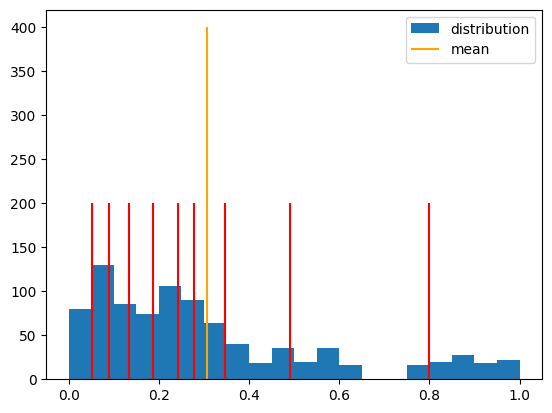

In [7]:
plt.hist(dist_n.flatten(), bins=20, label='distribution')
plt.vlines(mean, 0, 400, color='orange', label='mean')
for i in range(1, 10):
    plt.vlines(qs[i], 0, 200, color='red')
plt.legend()
plt.show()

In [26]:
eps = []
factor = 0.90
residuals = []
Ws = []
Hs = []
rands = []
preds = []
Anps = []
kmean = []

for i in range(50):
    ep = factor**i
    eps.append(ep)
    Anp = epsilon_graph_hard(dist_n, epsilon=ep)
    W, H, residual = nmf_sklearn(Anp, d=NB_CLUSTERS, max_iter=10000)
    #W, H, residual = sparse_nmf(Anp, NB_CLUSTERS, beta=0.1, eta=0)
    #W, H, residual = semi_nmf(Anp, NB_CLUSTERS, max_iters=1000, safeguard=True)
    #W, H, residual = sym_nmf(Anp, NB_CLUSTERS, lr=1e-4, sigma=0.1, max_iters=1000)
    #W, H, S, residual = rgnmf_multi(Anp, NB_CLUSTERS, alpha=1e-2, beta=1, max_iters=1000, safeguard=False, lower_limit=1e-4, higher_limit=1e4)
    #W, H, residual = kernel_nmf(Anp, NB_CLUSTERS, kernel='sigmoid', sigma=1.0, max_iters=2000)
    residuals.append(residual)
    Ws.append(W)
    Hs.append(H)
    Anps.append(Anp)
    kmean.append(rand_score(true_labels, kmeans(Anp, d=NB_CLUSTERS)))
    preds.append(np.argmax(W, axis=1))
    rands.append(rand_score(true_labels, np.argmax(W, axis=1)))



c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\jbhim\miniconda3\envs\timeseries\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(esti

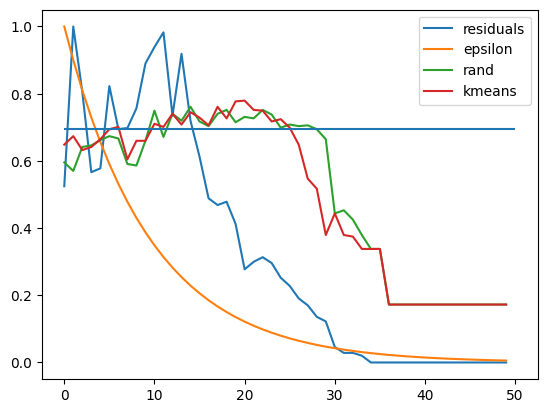

0.5094712643678162


In [27]:
plt.plot(residuals / np.max(residuals), label='residuals')
plt.plot(eps, label='epsilon')
plt.plot(rands, label='rand')
plt.plot(kmean, label='kmeans')
plt.hlines(random_score, 0.0, 50)
plt.legend()
plt.show()
print(np.mean(rands))

14
Rand score is 0.7609195402298851
Kmean score is 0.7011494252873564
Used epsilon is 0.2287679245496101


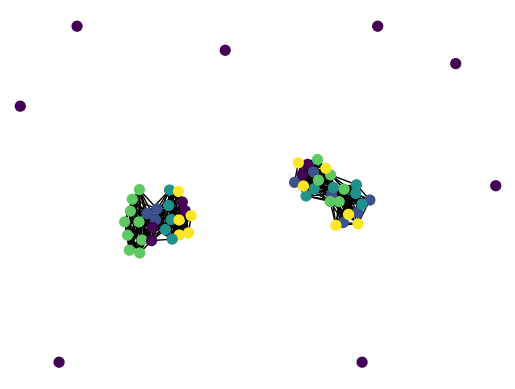

In [28]:
idx = np.argmax(rands)
print(idx)

print(f'Rand score is {rands[idx]}')
print(f'Kmean score is {rand_score(true_labels, kmeans(Anps[idx], d=NB_CLUSTERS))}')
print(f'Used epsilon is {eps[idx]}')
G = nx.from_numpy_array(Anps[idx])
plt.subplot(121)
nx.draw(G, node_color=preds[idx], node_size=50)
plt.subplot(122)
nx.draw(G, node_color=true_labels, node_size=50)    
plt.show()

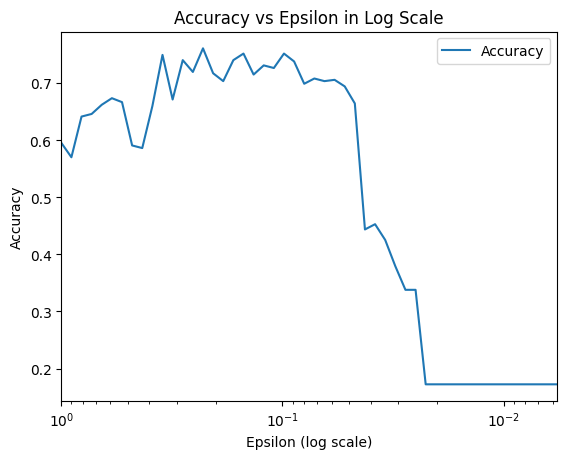

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have two arrays: epsilon_values and accuracy_values
epsilon_values = np.logspace(-5, -1, 100)  # Example epsilon values (adjust as needed)
accuracy_values = np.random.rand(100)  # Example accuracy values (replace with your actual data)

# Plotting in log scale
plt.plot(eps, rands, label='Accuracy')
plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon in Log Scale')
plt.xlim(eps[0], eps[-1])
plt.legend()
plt.show()


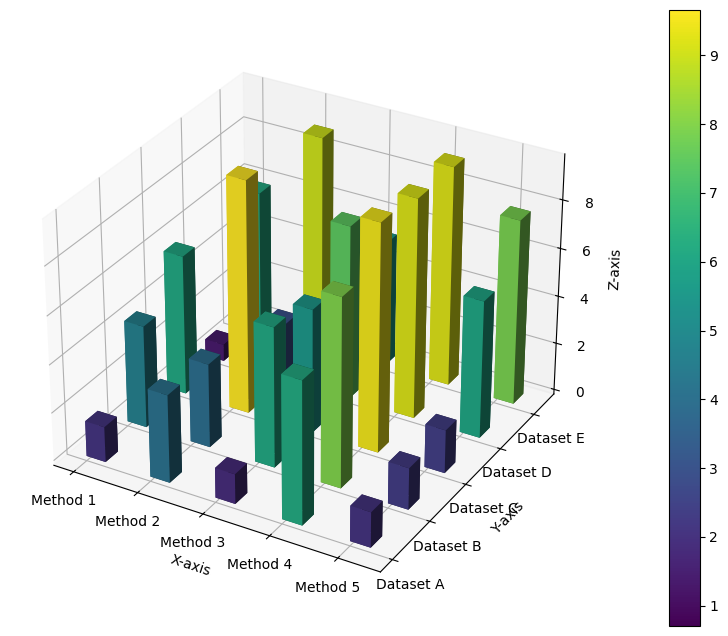

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a 2D array (replace this with your own data)
data = np.random.rand(5, 5) * 10
# Dummy dataset and method names
dataset_names = ['Dataset A', 'Dataset B', 'Dataset C', 'Dataset D', 'Dataset E']
method_names = ['Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5']

# Create a meshgrid for x and y
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = np.zeros_like(x)

# Adjust the bar width and separation
bar_width = 0.3
bar_gap = 0.0

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D bars with color based on height
for xi, yi, zi, value in zip(x, y, z, data.flatten()):
    color = plt.cm.viridis(value / data.max())  # Use viridis colormap, adjust as needed
    ax.bar3d(xi, yi, zi, bar_width, bar_width, value, shade=True, color=color, zsort='average')

# Create a color scale along the z-axis
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(data.flatten())
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)


# Customize x and y axis ticks and labels
ax.set_xticks(np.arange(len(method_names)))
ax.set_yticks(np.arange(len(dataset_names)))

ax.set_xticklabels(method_names)
ax.set_yticklabels(dataset_names)
# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Show the plot
plt.show()
